# Play Atari games with DQN

This notebook shows how to play image based Atari games (will leave out the RAM games since the pipeline can be very different) with DQN agents.

In [1]:
%matplotlib inline
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

In [2]:
class Qnet(Model):
    def __init__(self, action_space_size, state_shape):
        super(Qnet, self).__init__()
        self.action_space_size = action_space_size
        self.state_shape = state_shape
        # Define conv layers
        self.conv_in = Conv2D(16, 8, strides=(4, 4), activation='relu', input_shape=self.state_shape)
        self.conv_0 = Conv2D(32, 4, strides=(2, 2), activation='relu')
        self.flatten = Flatten()
        # Dense layers
        self.dense_0 = Dense(256, activation='relu')
        self.dense_out = Dense(self.action_space_size, activation='linear')
    
    def call(self, inputs):
        x = inputs
        x = self.conv_in(x)
        x = self.conv_0(x)
        x = self.flatten(x)
        x = self.dense_0(x)
        x = self.dense_out(x)
        return x

In [3]:
class ReplayBuffer:
    def __init__(self, max_length, state_shape, action_space_size):
        self.max_length = max_length
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.state_spec = tf.TensorSpec(state_shape, dtype=tf.float32, name='state')
        self.q_vals_spec = tf.TensorSpec([self.action_space_size], dtype=tf.float32, name='q_vals')
        self.buffer = TFUniformReplayBuffer(
            data_spec=(self.state_spec, self.q_vals_spec),
            batch_size=1,
            max_length=self.max_length)
    
    def add_batch(self, batch):
        self.buffer.add_batch(batch)
    
    def get_next(self, sample_batch_size=32):
        return self.buffer.get_next(sample_batch_size=sample_batch_size)

In [4]:
class DqnAgent:    
    def __init__(self, action_space_size, state_shape, train_per_eps, learning_rate):
        self.action_space_size = action_space_size
        self.state_shape = state_shape
        self.learning_rate = learning_rate
        self.train_per_eps = train_per_eps
        self.q_net = self.create_q_net()
        self.target_q_net = self.create_q_net()
        
    def update(self):
        self.target_q_net.set_weights(self.q_net.get_weights())
        
    def create_q_net(self):
        q_net = Qnet(self.action_space_size, self.state_shape)
        q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return q_net
    
    def random_policy(self, state):
        return np.random.randint(self.action_space_size)
    
    def net_policy(self, state):
        q_vals = self.get_q_vals(state).numpy()[0]
        action = np.argmax(q_vals)
        return action
    
    def collect_policy(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.random_policy(state)
        return self.net_policy(state)
    
    def get_next_q_vals(self, state):
        next_q_vals = self.target_q_net(tf.convert_to_tensor([state], dtype=tf.float32))
        return next_q_vals
    
    def get_q_vals(self, state):
        q_vals = self.q_net(tf.convert_to_tensor([state], dtype=tf.float32))
        return q_vals
    
    def train(self, replay_buffer, batch_size):
        loss = []
        for _ in range(self.train_per_eps):
            batch, info = replay_buffer.get_next(batch_size)
            states, target_q_vals = batch
            result = self.q_net.fit(x=states, y=target_q_vals, verbose=0)
            loss.append(result.history['loss'])
        return loss

In [5]:
class GameEnv:
    """
    Although OpenAI gym library provides most of the
    things we need, the state and reward it emits is
    too primative to be used. To keep the state and
    reward conversion consistent, we wrap the OpenAI
    gym environment in a shim class.
    """
    @staticmethod
    def sanitize_state(state, downsample=2):
        img = Image.fromarray(state).convert('L')
        w, h = img.size
        w, h = w // 2, h // 2
        img = np.array(img.resize((w, h)))
        normalized_img = img / 255.0
        return normalized_img
    
    @staticmethod
    def normalize_reward(reward):
        return reward
    
    def __init__(self, game_id, n_frames):
        self.game_id = game_id
        self.n_frames = n_frames
        self.env = gym.make(game_id)
        self.frames = deque(maxlen=self.n_frames)
        
    def get_action_space_size(self):
        return self.env.action_space.n
    
    def get_state_shape(self):
        initial_state = self.reset()
        return initial_state.shape
        
    def render(self):
        self.env.render()
        
    def get_frames(self):
        frames = np.array(self.frames)
        frames = np.swapaxes(frames, 0, 2)
        return frames
        
    def reset(self):
        unsanitized_initial_state = self.env.reset()
        initial_state = self.sanitize_state(unsanitized_initial_state)
        for _ in range(self.n_frames):
            self.frames.append(initial_state)
        return self.get_frames()
    
    def close(self):
        self.env.close()
    
    def step(self, action):
        unsanitized_state, unnormalized_reward, done, info = self.env.step(action)
        state = self.sanitize_state(unsanitized_state)
        self.frames.append(state)
        reward = self.normalize_reward(unnormalized_reward)
        return self.get_frames(), reward, done, info

In [6]:
def play_episode(env, agent, epsilon=0.0, gamma=0.9, collect=False, buffer=None, render=False, max_steps=100000):
    state = env.reset()
    done = False
    steps = 0
    total_reward = 0.0
    while not done and steps < max_steps:
        if render:
            env.render()
        action = agent.collect_policy(state, epsilon)
        next_state, reward, done, info = env.step(action)
        if collect:
            q_vals = agent.get_q_vals(state).numpy()[0]
            next_q_vals = agent.get_next_q_vals(next_state).numpy()[0]
            q_vals[action] = reward
            if not done:
                q_vals[action] += (next_q_vals.max() * gamma)
            buffer.add_batch((
                tf.convert_to_tensor([state], dtype=tf.float32),
                tf.convert_to_tensor([q_vals], dtype=tf.float32)
            ))
        state = next_state
        total_reward += reward
        steps += 1
    return total_reward

In [7]:
def init_tensorflow_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
    print('GPU initialized')

In [8]:
def visualize_training_result(loss, train_rewards, eval_rewards, epsilon, eps):
    fig, (loss_plt, train_plt, eval_plt) = plt.subplots(3, figsize=(20,5))
    fig.suptitle('Eps {0} with epsilon {1}'.format(eps, epsilon))
    loss_plt.plot(loss)
    train_plt.plot(train_rewards)
    eval_plt.plot(eval_rewards)
    plt.show()

In [9]:
def train_agent(max_eps=2000, initial_max_steps=512,
                max_steps_increase_amount=10,
                max_steps_increase_interval=5,
                render=False, max_buffer_len=1200,
                batch_size=128, visualize_interval=5,
                train_per_eps=10, learning_rate=1e-3,
                eval_interval=5, initial_epsilon=0.9,
                update_interval=5, epsilon_decay=0.95,
                epsilon_decay_interval=10,
                eval_eps=10):
    init_tensorflow_gpu()
    train_env = GameEnv('Breakout-v0', 4)
    eval_env = GameEnv('Breakout-v0', 4)
    state_shape = train_env.get_state_shape()
    action_space_size = train_env.get_action_space_size()
    epsilon = initial_epsilon
    max_steps = initial_max_steps
    buf = ReplayBuffer(max_buffer_len, state_shape, action_space_size)
    print('Initialize agent with state shape {0} and action space size {1}'.format(state_shape, action_space_size))
    agent = DqnAgent(action_space_size, state_shape, train_per_eps, learning_rate)
    loss = []
    train_rewards = []
    eval_rewards = []
    for eps in range(1, max_eps + 1):
        train_rewards.append(
            play_episode(
                train_env, agent, render=render, max_steps=max_steps,
                collect=True,buffer=buf, epsilon=epsilon, gamma=0.95
            )
        )
        loss += agent.train(buf, batch_size)
        if eps % eval_interval == 0:
            total_reward = 0.0
            for _ in range(eval_eps):
                total_reward += play_episode(
                    eval_env, agent, render=render, max_steps=max_steps,
                    collect=False)
            eval_rewards.append(total_reward/eval_eps)
        if eps % update_interval == 0:
            agent.update()
        if eps % max_steps_increase_interval == 0:
            max_steps += max_steps_increase_amount
        if eps % epsilon_decay_interval == 0:
            epsilon *= epsilon_decay
        if eps % visualize_interval == 0:
            visualize_training_result(loss, train_rewards, eval_rewards, epsilon, eps)
    env.close()
    print('Done')

1 Physical GPUs, 1 Logical GPUs
GPU initialized
Initialize agent with state shape (80, 105, 4) and action space size 4


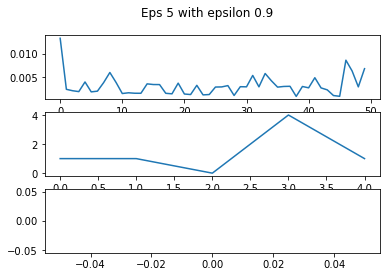

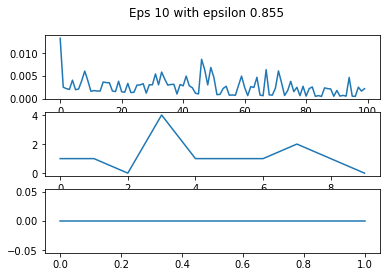

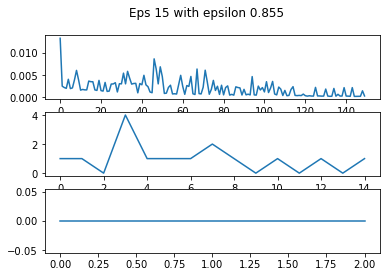

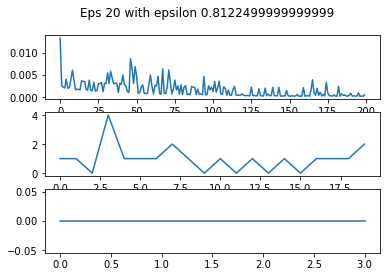

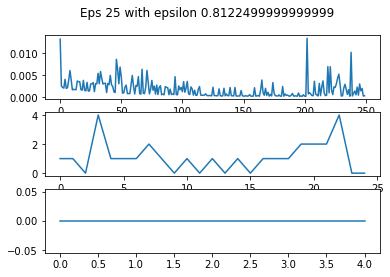

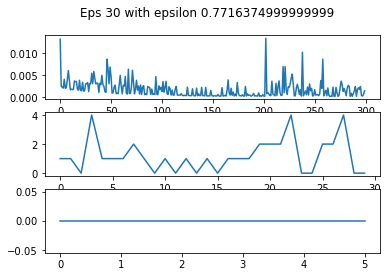

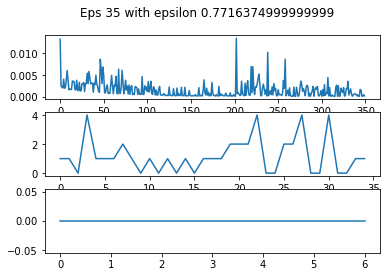

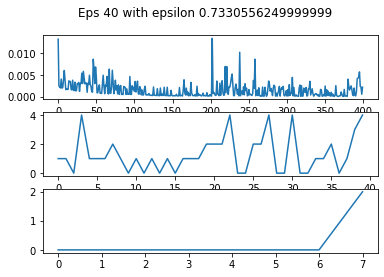

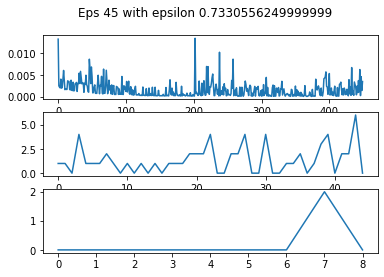

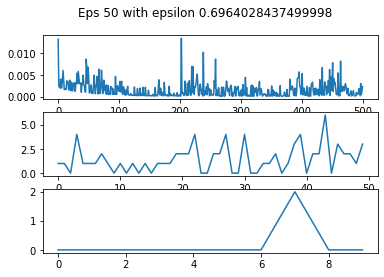

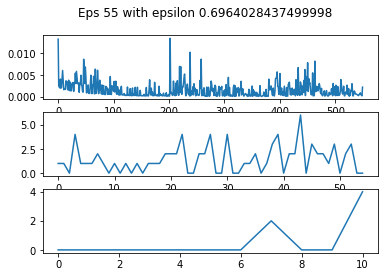

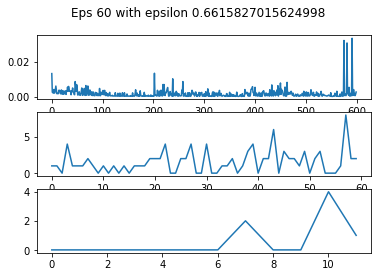

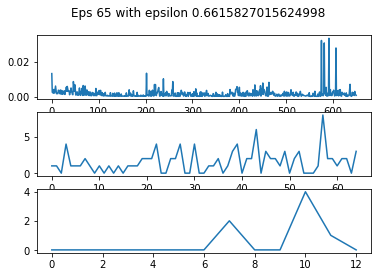

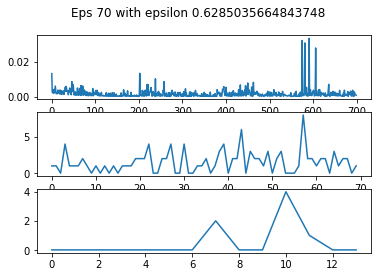

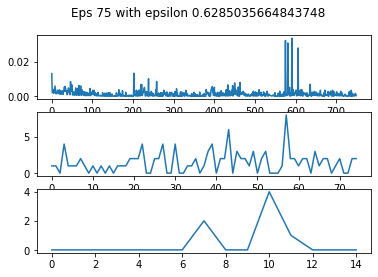

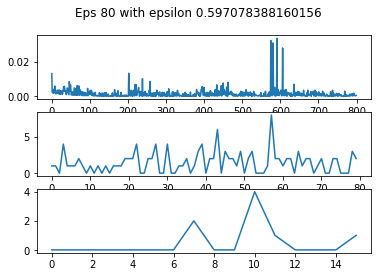

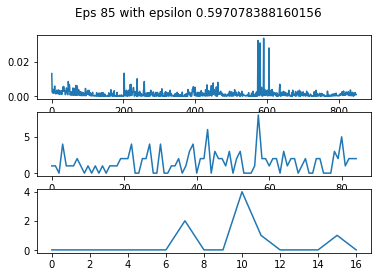

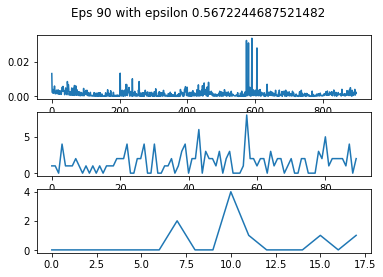

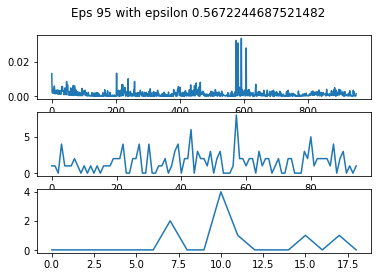

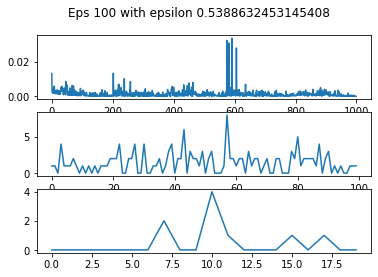

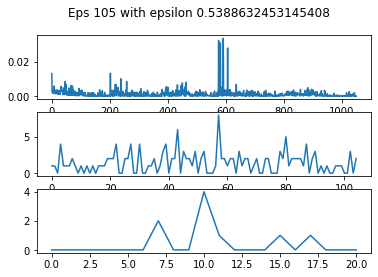

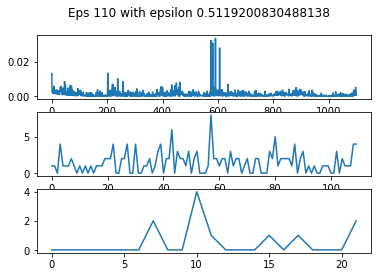

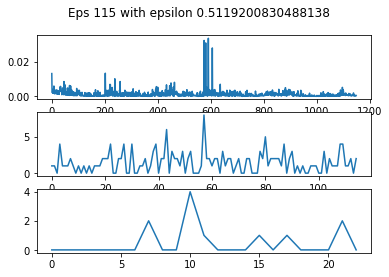

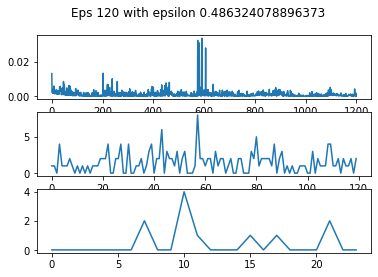

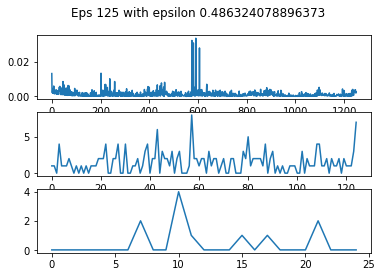

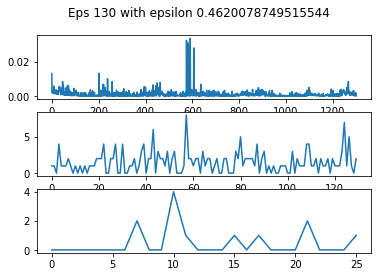

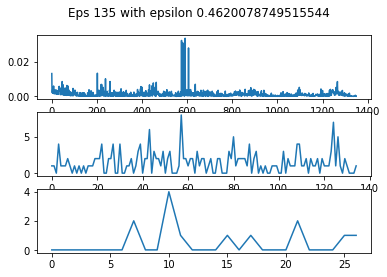

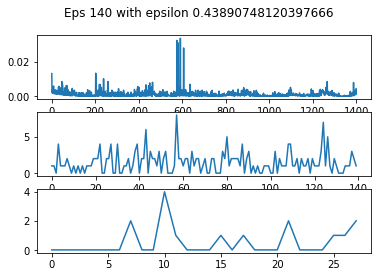

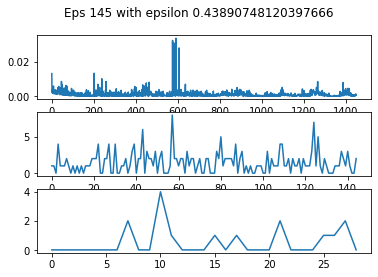

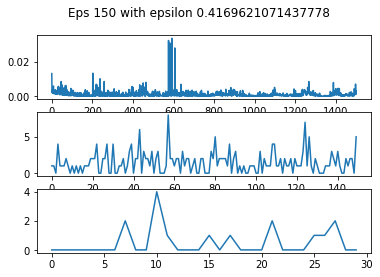

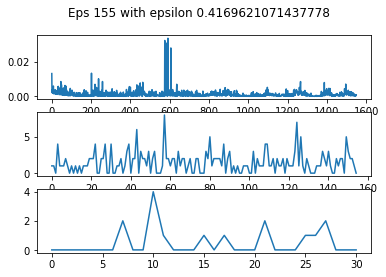

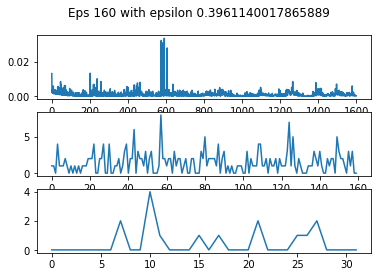

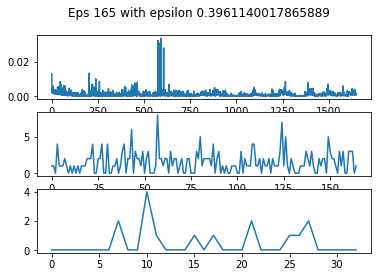

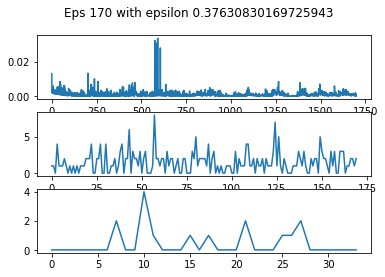

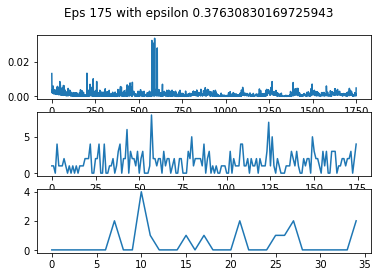

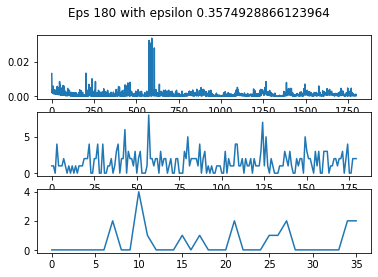

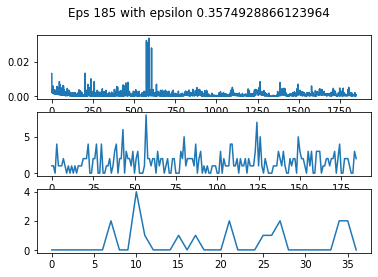

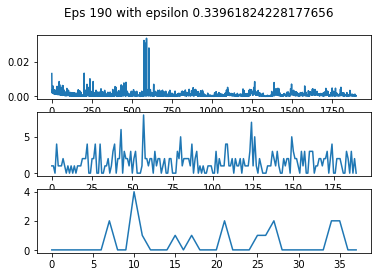

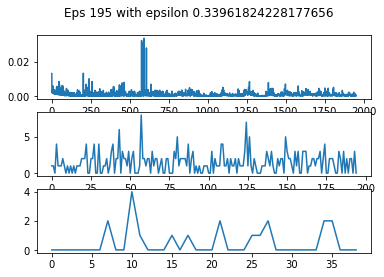

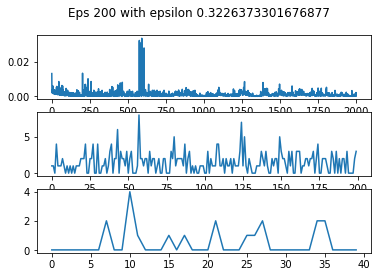

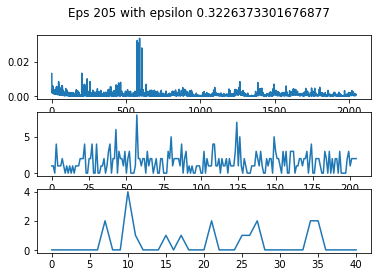

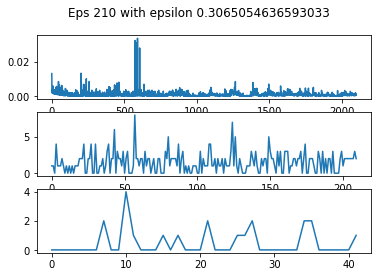

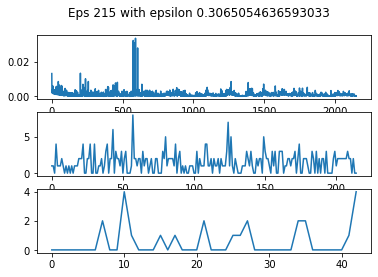

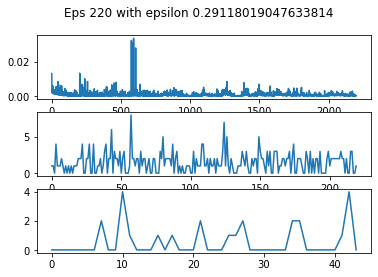

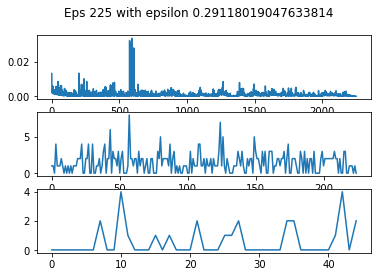

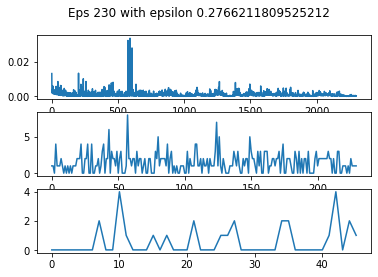

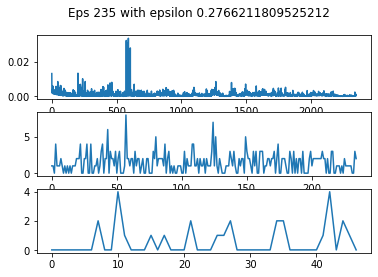

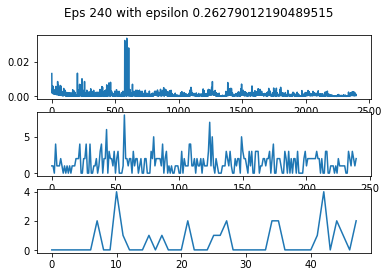

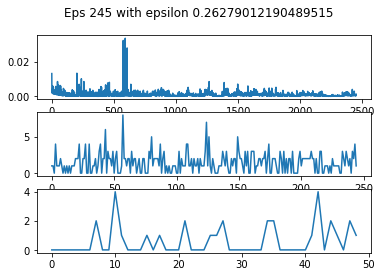

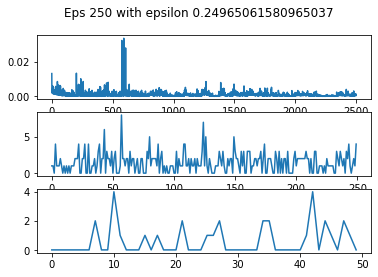

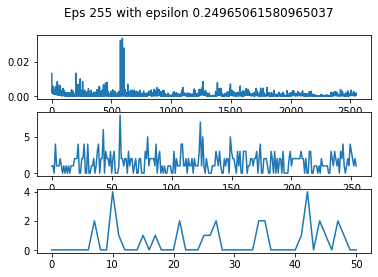

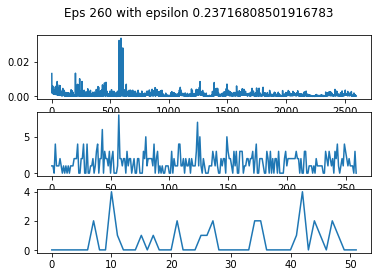

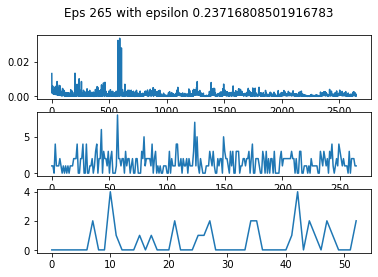

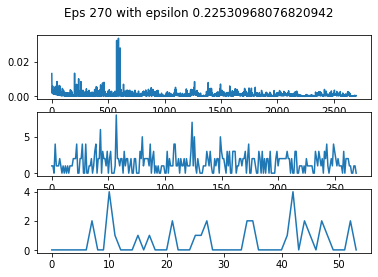

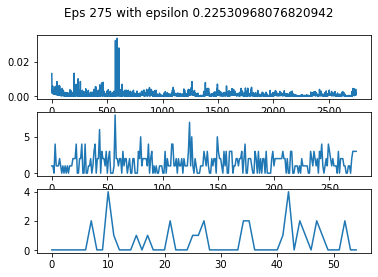

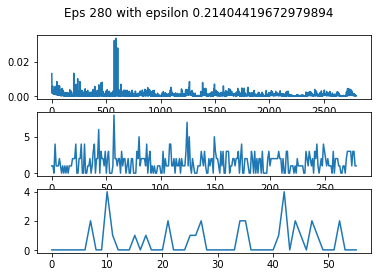

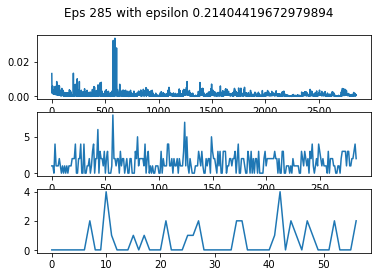

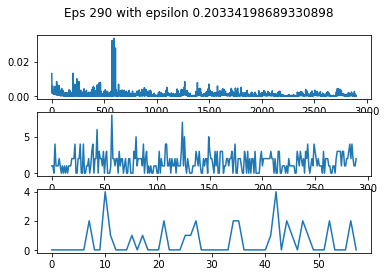

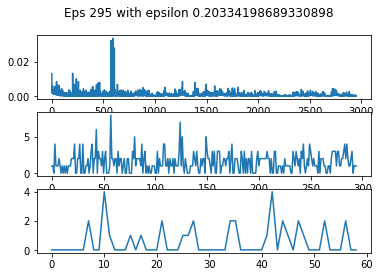

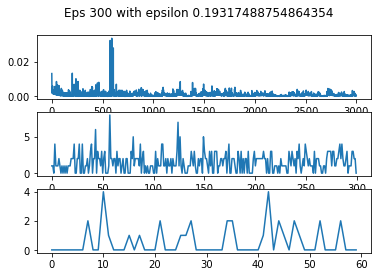

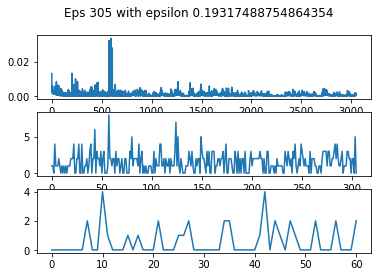

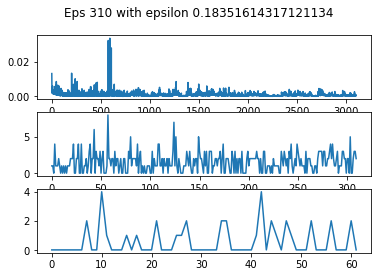

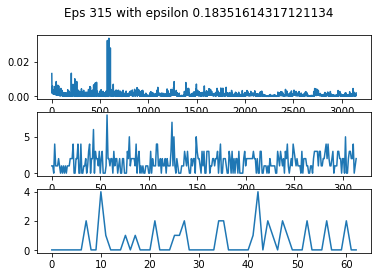

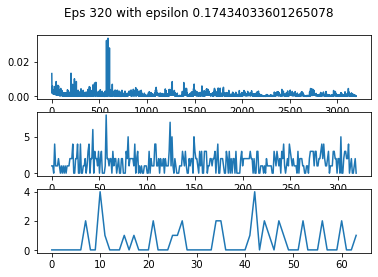

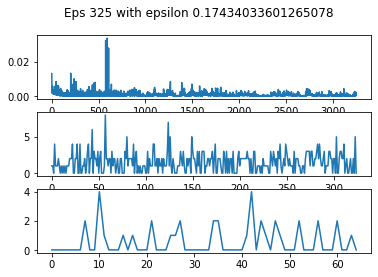

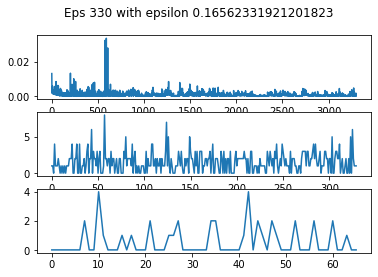

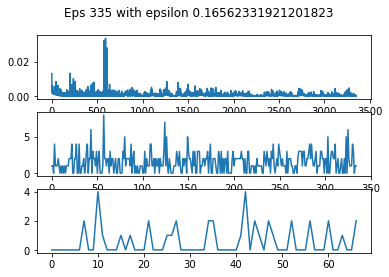

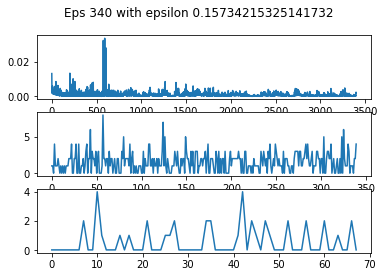

In [ ]:
train_agent(render=True)